<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 12: Boosting and Model Stacking</h2>
<br>

In this lesson we revisit house pricing dataset of [De Cock (2011)](http://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) (from Tutorial 7) and the corresponding [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Our goal is to develop a machine learning system that will perform well in the competition. Our final solution is based on model stacking using a linear regression, regularised linear models and gradient boosting as components. 

Boosting is one the most powerful learning algorithms developed in recent decades. In most settings, a carefully tuned boosting model is likely to be among the best algorithms immediately available for prediction, if not the best. A large scale empirical study by [Caruana and Niculescu-Mizil (2006)](https://dl.acm.org/ft_gateway.cfm?id=1143865&ftid=364245&dwn=1&CFID=7573757&CFTOKEN=aea5af1b7b29f94-E2D75B9E-EE4F-186B-FF2FDBF1F8C435D1) found that boosting was overall the most accurate algorithm for supervised learning across a variety of datasets, among competitors that included random forests, support vector machines and neural networks.  Boosting is also behind the [winning solutions](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions) to several machine learning competitions.  Due to the importance of this topic, we will move beyond <TT>Scikit-Learn</TT> to consider two specialised packages for gradient boosting: [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html) and [LightGBM](https://github.com/Microsoft/LightGBM).  

<a href="#House-Pricing-Data">House Pricing Data</a> <br>
<a href="#Linear-Regression">Linear Regression</a> <br>
<a href="#Regularised-Linear-Models">Regularised Linear Models</a> <br>
<a href="#Regression-Tree">Regression Tree</a> <br>
<a href="#Random-Forest">Random Forest</a> <br>
<a href="#Bagging">Bagging</a> <br>
<a href="#Boosting">Boosting</a> <br>
<a href="#Model-Stacking">Model Stacking</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>
<a href="#Making-a-Submission-on-Kaggle">Making a Submission on Kaggle</a> <br>

This notebook relies on the following libraries and settings.

Packages <TT>XGBoost</TT>, <TT>LightGBM</TT>, and <TT>mlxtend</TT> (for model stacking), used in this tutorial, can be installed by running the following in your anaconda prompt:
```javascript 
conda config --add channels conda-forge
conda install py-xgboost
conda install lightgbm
conda install mlxtend```

In [1]:
# Packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore') 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

## House Pricing Data

The original dataset has been cleaned and processed into a version that is ready for analysis. The dataset has 196 variables after coding the categorical predictors using dummy variables and the creation of other relevant variables. 

In [3]:
data=pd.read_csv('Datasets/AmesHousing-Processed.csv')
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Age,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,GarageArea,LotArea,...,RoofMatl_Other,RoofStyle_Hip,RoofStyle_Other,ScreenPorchZero,WoodDeckSFZero,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SalePrice
0,1656,0,0,50,639.0,0.0,441.0,0,528.0,31770,...,0,1,0,1,0,0,0,0,1,215000
1,896,0,0,49,468.0,144.0,270.0,0,730.0,11622,...,0,0,0,0,0,0,0,0,1,105000
2,1329,0,0,52,923.0,0.0,406.0,0,312.0,14267,...,0,1,0,1,0,0,0,0,1,172000
3,2110,0,0,42,1065.0,0.0,1045.0,0,522.0,11160,...,0,1,0,1,1,0,0,0,1,244000
4,928,701,0,13,791.0,0.0,137.0,0,482.0,13830,...,0,0,0,1,0,0,0,0,1,189900


As usual, we the split the data into training (70%) and test sets (30%).

In [4]:
response='SalePrice'
predictors=list(data.columns.values[:-1])

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=5)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

# Write training and test response vectors
y_train = np.log(train[response])
y_test = np.log(test[response])

# Write training and test design matrices
X_train = train[predictors].copy()
X_test = test[predictors].copy()

Note that our Y is the logarithm of the Sale Price.

First, we implement a number of familiar methods.

## Linear Regression 

In [5]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Regularised Linear Models


### Lasso

In [13]:
%%time

lasso = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(cv=5)),
))

lasso.fit(X_train, y_train)

Wall time: 354 ms


### Ridge Regression

In [12]:
%%time

alphas = list(np.logspace(-15, 15, 151, base=2))

ridge = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
))

ridge.fit(X_train, y_train)

Wall time: 8.03 s


### Elastic Net

In [11]:
%%time

enet = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)),
))

enet.fit(X_train, y_train)

Wall time: 3.38 s


## Regression Tree

In [9]:
%%time

model = DecisionTreeRegressor(min_samples_leaf=5)

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20],
    'max_depth': np.arange(1,30),
}

tree = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False)
tree.fit(X_train, y_train)

print('Best parameters:', tree.best_params_)

Best parameters: {'min_samples_leaf': 5, 'max_depth': 12}
Wall time: 2.06 s


## Bagging

We can use the following syntax to implement bagging for the regression trees (however, note that bagging is also a special case of random forests).

In [10]:
%%time

bag = BaggingRegressor(n_estimators=500, random_state=1)
bag.fit(X_train, y_train)

Wall time: 12.7 s


## Random Forest Regression

In [14]:
%%time

model = RandomForestRegressor(n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, return_train_score=False, n_jobs=4,
                              random_state = 20)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 1, 'max_features': 56} 

Wall time: 17.6 s


In [17]:
rf.n_estimators = 500
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=56, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

## Boosting

We start with the <TT>Sciki-Learn</TT> implementation of boosting available in the [<TT>GradientBoostingRegressor</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) class. Recall that boosting has three crucial tuning parameters:

<li style="margin-top:15px; margin-bottom: 10px"> The learning rate.</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The number of trees.</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The size of each tree.</li> 

In addition, we may want to use stochastic gradient boosting by fitting each tree based on a subsample of the training data. 

The basic syntax for fitting a gradient boosting regressor with <TT>Scikit-Learn</TT> is as follows. 

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(learning_rate= 0.05, max_depth = 4, n_estimators= 750, subsample = 1.0)
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=750, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

We use a randomised search to tune the model. Note that it useful to keep track of the running time, as the presence of multiple tuning parameters can make this process slow. 

In [20]:
%%time

model = GradientBoostingRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2 ,3, 4],
    'subsample' : [0.6, 0.8, 1.0]
}

# Using GridSearchCV would be too slow. Increase the number of iterations to explore more hyperparameter combinations.
gb = RandomizedSearchCV(model, tuning_parameters, n_iter = 20, cv = 10, return_train_score=False, n_jobs=4)
gb.fit(X_train, y_train)

print('Best parameters found by randomised search:', gb.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 1500, 'max_depth': 2, 'learning_rate': 0.1} 

Wall time: 4min 22s


In [21]:
gb.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1500, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False)

Our <TT>statlearning</TT> module contains a function for ploting the variable importances. 

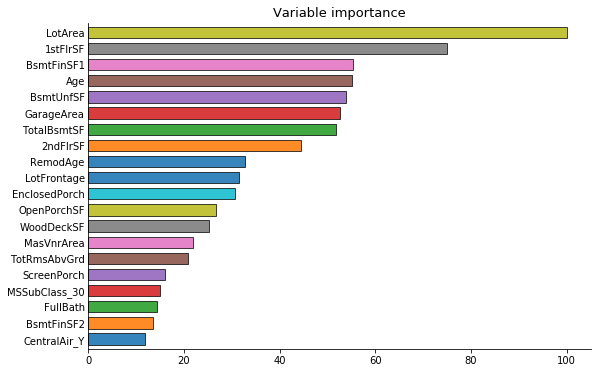

In [22]:
from statlearning import plot_feature_importance

plot_feature_importance(gb.best_estimator_, predictors)
plt.show()

### XGBoost

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a state-of-art gradient boosting library that is very popular among [Kaggle](https://www.kaggle.com/) users. The easiest way to get started with XGBoost is to use the [Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) provided by the package. That makes the syntax identical to what we did above, except that we call the [XGBRegressor](http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) class from the XGBoost package.  (Note that the <TT>xgboost</TT> package needs to be installed, see the beginning of the tutorial.)

In [23]:
%%time

model = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4,
                              random_state = 20)
gb_search.fit(X_train, y_train)

xbst = gb_search.best_estimator_


print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.1} 

Wall time: 1min 23s


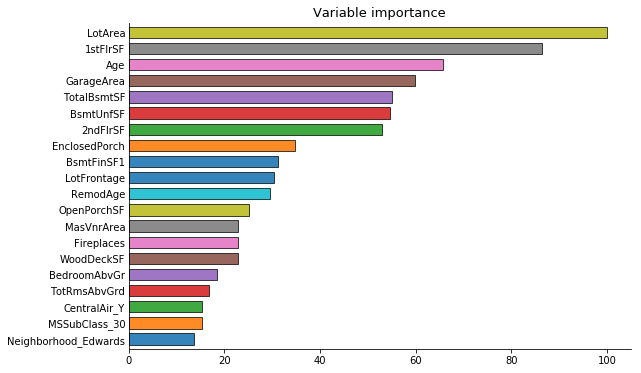

In [24]:
plot_feature_importance(xbst, labels=predictors)
plt.show()

The XGBoost functionately extends well beyond the <TT>Scikit-Learn API</TT>. Below, we construct a pure XGBoost implementation to select the number of boosting iterations by cross-validation and early stopping. 

In [25]:
%%time

dtrain = xgb.DMatrix(X_train, y_train) # we need to convert the data to the format required by xgboost
dtest  = xgb.DMatrix(X_test)

param = {
    'max_depth': 2, 
    'learning_rate': 0.1, 
    'subsample': 0.8,
    'silent' : 0, 
    'objective':'reg:linear',  
     }

cv = xgb.cv(param, dtrain, num_boost_round = 1500, nfold=10, early_stopping_rounds=50)

print(f'Selected number of boosting iterations: {cv.shape[0]}')
print(f'RMSE (CV): {cv.iloc[-1,0]:.4f}')

Selected number of boosting iterations: 836
RMSE (CV): 0.1008
Wall time: 47.1 s


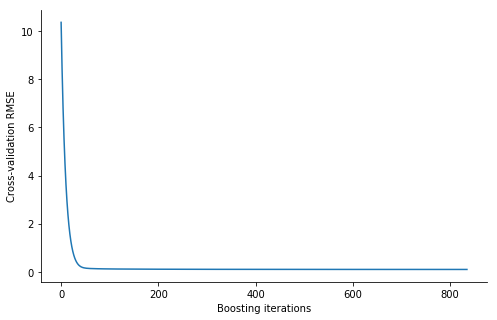

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(cv.iloc[:,0])
ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('Boosting iterations')
sns.despine()
plt.show()

### LightGBM


[LightGBM](http://lightgbm.readthedocs.io/en/latest/index.html) is a gradient boosting library developed by <TT>Microsoft</TT>, and it is a competitor to XGBoost. Similarly to XGBoost, it provides a [Scikit-Learn API](http://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api) that makes it simple to use. Notice how it runs much faster than the the <TT>Scikit-Learn</TT> implementation of boosting. (Note that the <TT>lightgbm</TT> package needs to be installed, see the beginning of the tutorial.)

In [27]:
%%time

model = lgb.LGBMRegressor(objective='regression')


tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 64, cv = 5, return_train_score=False, n_jobs=4, 
                               random_state = 20)

gb_search.fit(X_train, y_train)

lbst = gb_search.best_estimator_


print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.1} 

Wall time: 1min 1s


### Additive Boosting

This is an advanced specification. Since gradient boosting is an additive model fit by forward stagewise additive modelling, nothing stops us from fitting a gradient boosting model to the residuals of a linear regression specification, therefore boosting the linear model with additive trees. Below we fit the linear regression model using the Lasso.

The only disadvantage is that there are no immediately available functions to add this model to our stack. 

In [28]:
%%time

y_fit = lasso.predict(X_train)
resid = y_train - y_fit

model = lgb.LGBMRegressor(objective='regression')


tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4, 
                               random_state = 20)

gb_search.fit(X_train, resid)

abst = gb_search.best_estimator_


print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 250, 'max_depth': 2, 'learning_rate': 0.01} 

Wall time: 15 s


## Model Stacking

Model stacking is a learning method that aims to improve predictive accuracy by combining predictions from multiple models. (Note that the <TT>mlxtend</TT> package needs to be installed, see the beginning of the tutorial.)

In [29]:
%%time

models = [ols, lasso, ridge, xbst]

stack = StackingCVRegressor(models, meta_regressor = LinearRegression(), cv=10)
stack.fit(X_train.values, y_train.ravel())

Wall time: 1min 47s


## Model Evaluation


### Original prices

To make predictions in the original prices, we exponentiate the y values.

In [30]:
columns=['Test RMSE', 'Test R2']
rows=['OLS', 'Lasso', 'Ridge', 'Elastic Net', 'Tree', 'Bagged Trees', 'Random Forest', 'SKLearn Boost', 'XGBoost', 'LightGBM', 'Additive Boost', 'Stack']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, lasso, ridge, enet, tree, bag, rf, gb, xbst, lbst, abst, stack]

for i, method in enumerate(methods):
    
    if method != stack:
        y_pred=np.exp(method.predict(X_test))   
        if method == abst:
            y_pred=np.exp(lasso.predict(X_test)+method.predict(X_test)) # combining predictions           
    else:
        y_pred=np.exp(method.predict(X_test.values))
        
    results.iloc[i,0] = np.sqrt(mean_squared_error(np.exp(y_test), y_pred))
    results.iloc[i,1] = r2_score(np.exp(y_test), y_pred)

results.round(3)

,Test RMSE,Test R2
OLS,14875.800,0.950
Lasso,14791.127,0.951
Ridge,14704.635,0.951
Elastic Net,14791.233,0.951
Tree,30644.863,0.789
Bagged Trees,24435.638,0.866
Random Forest,23860.810,0.872
SKLearn Boost,15627.670,0.945
XGBoost,16333.013,0.940
LightGBM,17415.512,0.932


### Log prices

Here we look at how well our models predict the log prices.

In [32]:
columns=['Test RMSE', 'Test R2']
rows=['OLS', 'Lasso', 'Ridge', 'Elastic Net', 'Tree', 'Bagged Trees', 'Random Forest', 'SKLearn Boost', 'XGBoost', 'LightGBM', 'Additive Boost', 'Stack']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, lasso, ridge, enet, tree, bag, rf, gb, xbst, lbst, abst, stack]

for i, method in enumerate(methods):
    
    if method != stack:
        y_pred= method.predict(X_test)   
        if method == abst:
            y_pred=ols.predict(X_test)+method.predict(X_test)              
    else:
        y_pred= method.predict(X_test.values)
        
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i,1] = r2_score(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2
OLS,0.083,0.945
Lasso,0.085,0.942
Ridge,0.084,0.944
Elastic Net,0.085,0.942
Tree,0.162,0.789
Bagged Trees,0.113,0.897
Random Forest,0.112,0.900
SKLearn Boost,0.085,0.942
XGBoost,0.087,0.940
LightGBM,0.088,0.938


## Making a Submission on Kaggle

Methods from this tutorial would allow one to get a competitive score at the [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Note that the Kaggle competition is based on predicting the log prices. 

The next cell shows you how to generate a submission file (note that Kaggle requires inclusion of the Id column, which does not exist in our version of the dataset). 

In [35]:
submission = pd.DataFrame(np.c_[test.index, y_pred], columns=['Id', response])
submission['Id'] = submission['Id'].astype(int)
submission.to_csv('kaggle_submission.csv',  index=False)